In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ANÁLISIS EXPLORATORIO

In [95]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')


In [96]:

print('HEAD')
df.head()
print('INFO')
df.info()
print('DESCRIBE')
df.describe()

HEAD
INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
DESCRIBE


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


In [97]:
df['v1'].value_counts()

v1
ham     4825
spam     747
Name: count, dtype: int64

In [98]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [99]:
df['v2'].str.len().describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: v2, dtype: float64

In [100]:
ham_words = ' '.join(df[df['v1'] == 'ham']['v2']).split()
spam_words = ' '.join(df[df['v1'] == 'spam']['v2']).split()

from collections import Counter

ham_counter = Counter(ham_words)
spam_counter = Counter(spam_words)

print("Palabras más comunes en mensajes ham:")
print(ham_counter.most_common(10))

print("\nPalabras más comunes en mensajes spam:")
print(spam_counter.most_common(10))

Palabras más comunes en mensajes ham:
[('to', 1530), ('you', 1458), ('I', 1436), ('the', 1019), ('a', 969), ('and', 738), ('i', 736), ('in', 734), ('u', 645), ('is', 638)]

Palabras más comunes en mensajes spam:
[('to', 604), ('a', 358), ('your', 187), ('call', 185), ('or', 185), ('the', 178), ('2', 169), ('for', 169), ('you', 164), ('is', 143)]


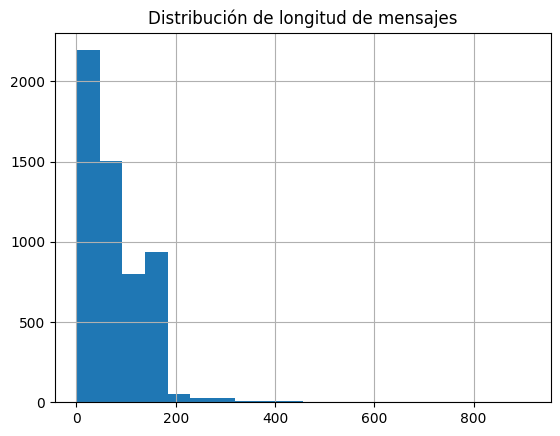

In [101]:

df['v2'].str.len().hist(bins=20)
plt.title('Distribución de longitud de mensajes')
plt.show()

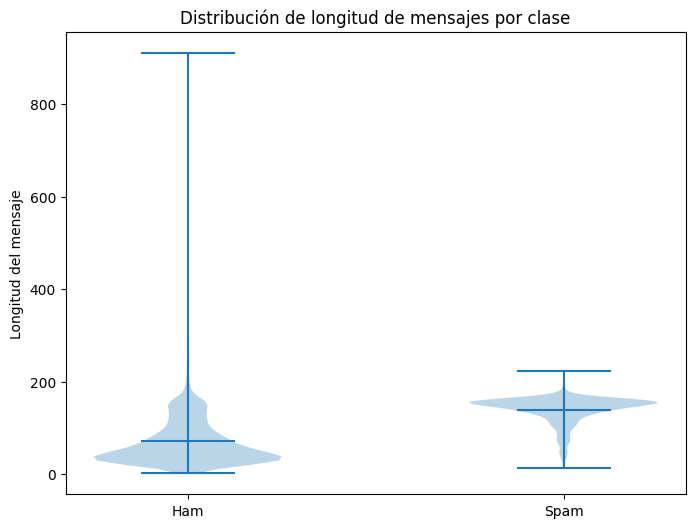

In [102]:
plt.figure(figsize=(8, 6))
plt.violinplot(dataset=[df[df['v1'] == 'ham']['v2'].str.len(), df[df['v1'] == 'spam']['v2'].str.len()],
               showmeans=True)
plt.xticks([1, 2], ['Ham', 'Spam'])
plt.title('Distribución de longitud de mensajes por clase')
plt.ylabel('Longitud del mensaje')
plt.show()

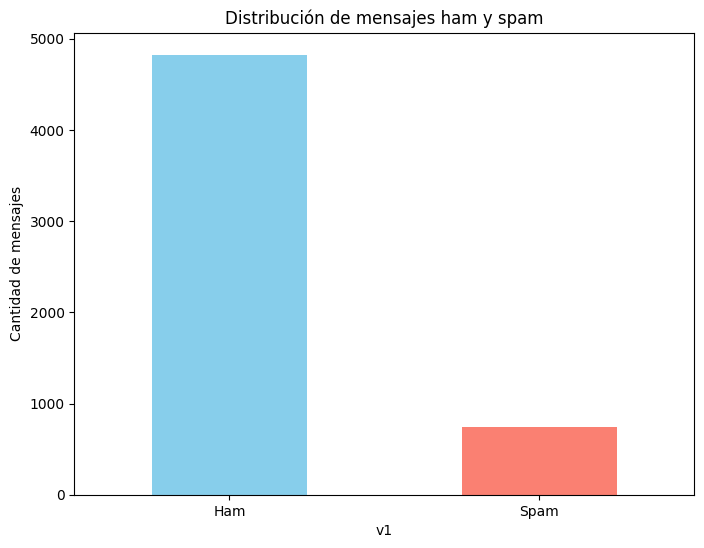

In [103]:
#cantidad de ham y spam 

plt.figure(figsize=(8, 6))

df['v1'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribución de mensajes ham y spam')
plt.ylabel('Cantidad de mensajes')
plt.xticks([0, 1], ['Ham', 'Spam'], rotation=0)

plt.show()


# LIMPIEZA DE DATOS 

In [104]:
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jsken\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [105]:
import re

def clean_text(text):
    # Remover caracteres especiales y números
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Convertir a minúsculas
    text = text.lower()
    
    # Tokenizar el texto
    tokens = nltk.word_tokenize(text)
    
    # Remover stop words
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lematización
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Stemming
    tokens = [stemmer.stem(word) for word in tokens]
    
    
    return tokens

In [106]:
df['v2_cleaned'] = df['v2'].apply(clean_text)

#crear nuevo dataframe con las palabras limpias y su tipo de mensaje
df_cleaned = df[['v1', 'v2_cleaned']].copy()

#cambia el nombre de las columnas  para que sea más entendible
df_cleaned.columns = ['label', 'message']

df_cleaned.head()

,label,message
0,ham,"[go, jurong, point, crazi, avail, bugi, n, gre..."
1,ham,"[ok, lar, joke, wif, u, oni]"
2,spam,"[free, entri, wkli, comp, win, fa, cup, final,..."
3,ham,"[u, dun, say, earli, hor, u, c, alreadi, say]"
4,ham,"[nah, dont, think, go, usf, life, around, though]"


# MODELO

## probabilidad de que una palabra sea SPAM

In [107]:
# Contar el número total de mensajes spam y ham
spam_count = df_cleaned[df_cleaned['label'] == 'spam'].shape[0]
ham_count = df_cleaned[df_cleaned['label'] == 'ham'].shape[0]
total_count = spam_count + ham_count

# Calcular P(S) y P(H)
P_spam = spam_count / total_count
P_ham = ham_count / total_count

# Función para calcular P(W|S) y P(W|H)
def calc_word_prob(word, spam_messages, ham_messages):
    spam_word_count = spam_messages[spam_messages['message'].apply(lambda x: word in x)].shape[0]
    ham_word_count = ham_messages[ham_messages['message'].apply(lambda x: word in x)].shape[0]
    
    P_word_spam = (spam_word_count + 1) / (spam_count + 2)  # Suavizado de Laplace
    P_word_ham = (ham_word_count + 1) / (ham_count + 2)  # Suavizado de Laplace
    
    return P_word_spam, P_word_ham

In [108]:
# Función para calcular P(W|S) y P(W|H)
def calc_spam_probability(word):
    P_word_spam, P_word_ham = calc_word_prob(word, df_cleaned[df_cleaned['label'] == 'spam'], df_cleaned[df_cleaned['label'] == 'ham'])
    
    P_spam_given_word = (P_word_spam * P_spam) / (P_word_spam * P_spam + P_word_ham * P_ham)
    
    return P_spam_given_word

In [109]:
#calcular la probabilidad de que una palabra sea spam 
word = 'free'

P_spam_given_word = calc_spam_probability(word)

print(f'La probabilidad de que el mensaje sea spam dado que contiene la palabra "{word}" es: {P_spam_given_word:.4f}')


La probabilidad de que el mensaje sea spam dado que contiene la palabra "free" es: 0.7419


## probabilidad de que un texto sea SPAM dado que contiene un conjunto de palabras utilizando la fórmula proporcionada

In [110]:
from functools import reduce

'''
Probabilidad de que un texto sea SPAM dado que contiene las palabras W1 a Wn: 𝑃(𝑆|𝑾)=(𝑃1𝑃2...𝑃n)/(𝑃1𝑃2...𝑃n+(1−𝑃1)(1−𝑃2)...(1−𝑃2))

donde P(W) = (Nws/Ns)/((Nwh/Nh)+(Nws/Ns))
Donde,  
N ws es la cantidad de correos SPAM que contienen la palabra W.  
N wh es la cantidad de correos HAM que contiene la palabra W.  
N s es la cantidad de correo de SPAM 
N h es la cantidad de correos de HAM.  

'''
def calc_spam_probability_text(text):
    words = clean_text(text)
    P_spam_given_words = [calc_spam_probability(word) for word in words]
    
    P_spam_given_text = reduce(lambda x, y: x * y, P_spam_given_words) / (reduce(lambda x, y: x * y, P_spam_given_words) + reduce(lambda x, y: x * y, [1 - prob for prob in P_spam_given_words]))
    
    return P_spam_given_text



In [111]:
text = 'claim your free iphone now'
P_spam_given_text = calc_spam_probability_text(text)

print(f'La probabilidad de que el mensaje sea spam dado el texto "{text}" es: {P_spam_given_text:.4f}')

La probabilidad de que el mensaje sea spam dado el texto "claim your free iphone now" es: 0.9937


# PRUEBAS DE RENDIMIENTO

In [112]:
'''
Pruebas de rendimiento. 
Considerando que genero un modelo utilizando un subconjunto de datos 
de entrenamiento, mida el rendimiento de su modelo sobre el dataset de 
prueba.  
Basándose en los valores de la matriz de confusión, obtenga valores de 
recall, precisión y f1-score de su modelo.  

'''


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

X = df['v2']
y = df['v1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df_train = pd.DataFrame({'label': y_train, 'message': X_train})
df_test = pd.DataFrame({'label': y_test, 'message': X_test})

df_train['message'] = df_train['message'].apply(clean_text)
df_test['message'] = df_test['message'].apply(clean_text)






In [113]:
df_test

,label,message
3245,ham,"[funni, fact, nobodi, teach, volcano, erupt, t..."
944,ham,"[sent, score, sopha, secondari, applic, school..."
1044,spam,"[know, someon, know, fanci, call, find, pobox,..."
2484,ham,"[promis, get, soon, youll, text, morn, let, kn..."
812,spam,"[congratul, ur, award, either, cd, gift, vouch..."
...,...,...
4264,ham,"[ltdecimalgt, common, car, better, buy, china,..."
2439,ham,"[rightio, well, arent, bright, earli, morn]"
5556,ham,"[ye, that, u, text, pshewmiss, much]"
4205,ham,"[get, door, im]"


In [114]:
def calc_spam_probability_text_predict(text):
    words = clean_text(text)
    
    if not words:
        # Manejar el caso de una lista vacía
        return 0.5  # O cualquier otra probabilidad predeterminada
    
    P_spam_given_words = [calc_spam_probability_predict(word) for word in words]
    
    P_spam_given_text = reduce(lambda x, y: x * y, P_spam_given_words) / (
        reduce(lambda x, y: x * y, P_spam_given_words) +
        reduce(lambda x, y: x * y, [1 - prob for prob in P_spam_given_words])
    )
    
    return P_spam_given_text

def calc_spam_probability_predict(word):
    P_word_spam, P_word_ham = calc_word_prob(word, df_test[df_test['label'] == 'spam'], df_test[df_test['label'] == 'ham'])
    
    P_spam_given_word = (P_word_spam * P_spam) / (P_word_spam * P_spam + P_word_ham * P_ham)
    
    return P_spam_given_word

In [115]:
def predict_spam_probability_text(text):
    P_spam_given_text = calc_spam_probability_text_predict(text)
    
    return 'spam' if P_spam_given_text > 0.5 else 'ham'

df_test['predicted'] = df_test['message'].apply(lambda x: predict_spam_probability_text(' '.join(x)))


TypeError: reduce() of empty iterable with no initial value

In [ ]:
conf_matrix = confusion_matrix(df_test['label'], df_test['predicted'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
